## Imports

In [29]:
import numpy as np
import scanpy as sc 
import umap
import sklearn.manifold as manifold
import matplotlib.pylab as plt
from t_sne import *

## Data preprocessing

### Single-cell multione gene expression

In [3]:
multiome = sc.read_h5ad("data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
gex = multiome[:6000, multiome.var["feature_types"] == "GEX"]

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [5]:
gex_data = gex[:, gex.var["highly_variable"]].X
gex_data.shape # should be (6k, 2500)

(6000, 2500)

In [6]:
gex_labels = gex.obs["cell_type"].values
gex_labels

['Naive CD20+ B IGKC+', 'CD14+ Mono', 'Naive CD20+ B IGKC+', 'HSC', 'Reticulocyte', ..., 'CD16+ Mono', 'CD4+ T activated', 'gdT CD158b+', 'CD14+ Mono', 'Naive CD20+ B IGKC-']
Length: 6000
Categories (42, object): ['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T CD314+ CD45RA+', 'CD4+ T activated', ..., 'cDC2', 'gdT CD158b+', 'gdT TCRVD2+', 'pDC']

## Evaluation

The evaluation pipeline is the follwoing:

1) Apply dimensionality reduction technique (Laplacian Eigenmaps, t-SNE, UMAP) to the data (application)

2) Compute quantitative metrics for the 2D embedding (KL divergence and Spearman's rank correlation) (quantitative metrics)

3) Plot the embedding (visualization)

4) Perform Leiden clustering on the embedding and based on cluster labels compute ARI, AMI, Homogenuity and Completeness metrics to further assess the quality of the embedding (clustering metrics)


In [35]:
import sklearn.metrics as sm
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

def get_kld(data, embedding, sigmas=None):
    negsqd = -pairwise_sq_distances(data)
    if sigmas is None:
        sigmas = find_exact_sigmas(negsqd, 30)
    P = p_joint_probabilities(negsqd, sigmas)
    Q, _ = q_joint_probabilities(embedding)
    kld = kl_divergence(P, Q)
    return kld, sigmas

def get_src(data, embedding):
    original_distances = pdist(data, metric='euclidean')
    embedded_distances = pdist(embedding, metric='euclidean')
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    return spearman_corr

def get_quantitative_metrics(data, embedding, sigmas=None):
    kld, sigmas = get_kld(data, embedding, sigmas)
    src = get_src(data, embedding)
    print("KL Divergence:", kld)
    print("Spearman's Rank Correlation:", src)
    return kld, src, sigmas

def plot_embedding(embedding, labels):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    handles = []
    for i, label in enumerate(np.unique(labels)):
        handle = axs[0].scatter(embedding[labels==label, 0], embedding[labels==label, 1], s=1., label=label)
        handles.append(handle)

    axs[1].legend(handles, np.unique(labels), ncol=2)

    plt.xlabel("EMB1")
    plt.ylabel("EMB2")
    plt.show()

def get_clustering_metrics(embedding, labels, resolution=0.2):
    anndata = sc.AnnData(embedding)
    sc.pp.neighbors(anndata, use_rep="X")
    sc.tl.leiden(anndata, resolution=resolution)
    cluster_labels = anndata.obs["leiden"].values
    print("Number of Leiden clusters:", np.unique(cluster_labels).shape)
    ari = sm.adjusted_rand_score(labels, cluster_labels)
    ami = sm.adjusted_mutual_info_score(labels, cluster_labels)
    homogeneity = sm.homogeneity_score(labels, cluster_labels)
    completeness = sm.completeness_score(labels, cluster_labels)
    print("""
    ARI: {}\n
    AMI: {}\n
    Homogenuity: {}\n
    Completeness: {}\n
    Avarage: {}
    """.format(ari, ami, homogeneity, completeness, (ari+ami+homogeneity+completeness)/4))
    return ari, ami, homogeneity, completeness

### t-SNE

Application

In [53]:
tsne1 = TSNE(
    n_components=2,
    num_iters=1000,
    compression_period=0,
    random_walk=False
)

In [55]:
tsne1.get_highdimensional_similarities(np.asarray(gex_data.toarray()))

Finding sigmas


100%|██████████| 6000/6000 [16:44<00:00,  5.97it/s]


Quantitative metrics

In [56]:
tsne1_embedding = tsne1.fit()

Running gradient descent...


100%|██████████| 1000/1000 [1:12:15<00:00,  4.34s/it]


In [57]:
src = get_src(np.asarray(gex_data.toarray()), tsne1_embedding)
kld = tsne1.metrics["kl_divergence"][-1]

print("KLD", kld)
print("SRC:", src)

KLD 1.2361045449720829
SRC: 0.4184989046125256


Visualization

c:\Users\dimon\Documents\studia\22-23\MMML\MMML_project\t_sne.py:467: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


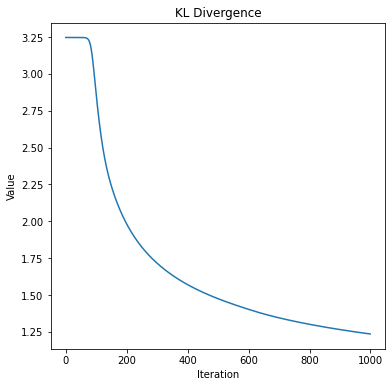

In [58]:
tsne1.plot_metrics()

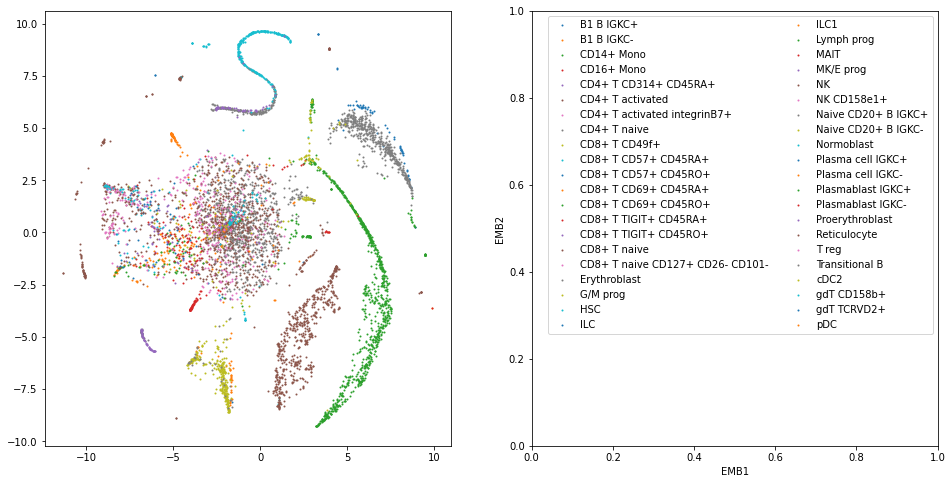

In [59]:
plot_embedding(tsne1_embedding, gex_labels)

Clustering metrics

In [60]:
get_clustering_metrics(tsne1_embedding, gex_labels)

C:\Users\dimon\AppData\Local\Temp\ipykernel_29020\2734164334.py:41: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(embedding)


Number of Leiden clusters: (29,)

    ARI: 0.33268277021354387

    AMI: 0.601271291669105

    Homogenuity: 0.6078331883561651

    Completeness: 0.6187307063971034

    Avarage: 0.5401294891589793
    


(0.33268277021354387,
 0.601271291669105,
 0.6078331883561651,
 0.6187307063971034)

### Optimized t-SNE

### sklearn t-SNE

In [31]:
reducer = manifold.TSNE()
skl_tsne_embedding = reducer.fit_transform(np.asarray(gex_data.toarray()))

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [33]:
skl_tsne_embedding.shape

(6000, 2)

In [38]:
_, _, sigmas = get_quantitative_metrics(np.asarray(gex_data.toarray()), skl_tsne_embedding)

Finding sigmas


100%|██████████| 6000/6000 [16:13<00:00,  6.16it/s]


KL Divergence: 0.8222000105299371
Spearman's Rank Correlation: 0.5826561372615193


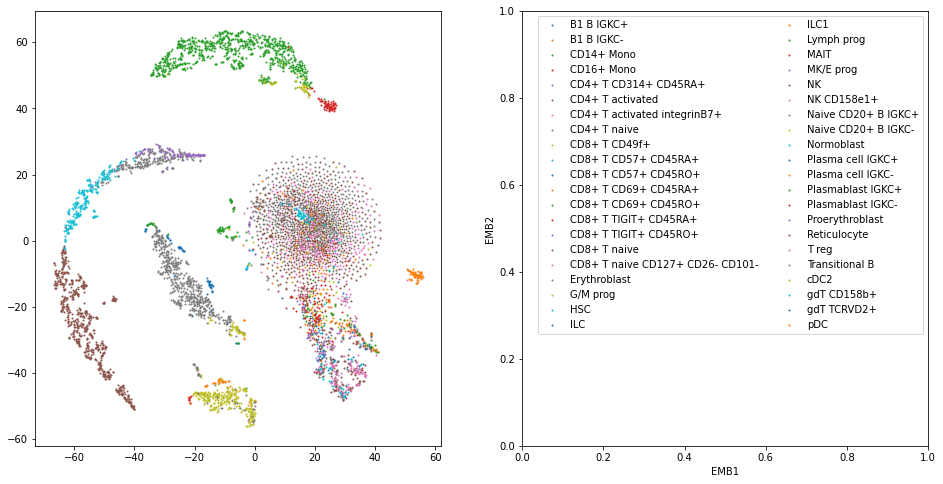

In [39]:
plot_embedding(skl_tsne_embedding, gex_labels)

In [40]:
get_clustering_metrics(skl_tsne_embedding, gex_labels)

Number of Leiden clusters: (28,)

    ARI: 0.3511318724124093

    AMI: 0.6422018070573464

    Homogenuity: 0.6355086588399251

    Completeness: 0.6711337184050788

    Avarage: 0.5749940141786899
    


(0.3511318724124093,
 0.6422018070573464,
 0.6355086588399251,
 0.6711337184050788)

### Laplacian Eigenmaps

Application

In [43]:
reducer = manifold.SpectralEmbedding(n_components=2)
le_embedding = reducer.fit_transform(np.asarray(gex_data.toarray()))

In [42]:
le_embedding.shape

(6000, 2)

Quantitative metrics

In [44]:
get_quantitative_metrics(np.asarray(gex_data.toarray()), le_embedding, sigmas)

KL Divergence: 3.246582359892793
Spearman's Rank Correlation: 0.760865371653157


(3.246582359892793,
 0.760865371653157,
 array([1.00000000e-20, 2.01915385e+01, 9.78092393e+00, ...,
        1.56428978e+01, 2.27597188e+01, 9.17923746e+00]))

Visualization

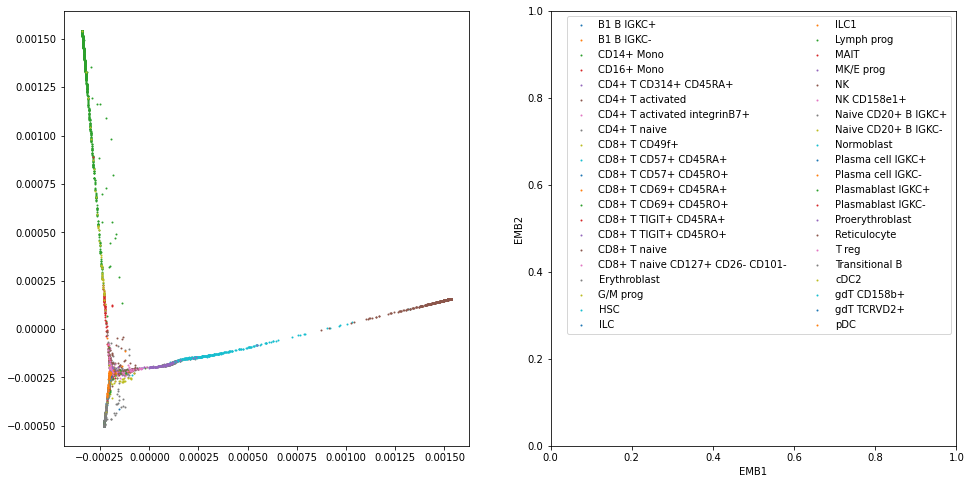

In [45]:
plot_embedding(le_embedding, gex_labels)

Clustering metrics

In [46]:
le_ari, le_ami, le_homogenuity, le_completeness = get_clustering_metrics(le_embedding, gex_labels)

C:\Users\dimon\AppData\Local\Temp\ipykernel_29020\2734164334.py:41: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata = sc.AnnData(embedding)


Number of Leiden clusters: (28,)

    ARI: 0.22927441294013415

    AMI: 0.5407942200716732

    Homogenuity: 0.5654430375325478

    Completeness: 0.544904476311448

    Avarage: 0.47010403671395073
    


### UMAP

Application

In [47]:
reducer = umap.UMAP(n_components=2)
umap_embedding = reducer.fit_transform(gex_data)

Quantitative metrics

In [50]:
get_quantitative_metrics(np.asarray(gex_data.toarray()), umap_embedding, sigmas)

KL Divergence: 1.3655009099149331
Spearman's Rank Correlation: 0.6278176605598447


(1.3655009099149331,
 0.6278176605598447,
 array([1.00000000e-20, 2.01915385e+01, 9.78092393e+00, ...,
        1.56428978e+01, 2.27597188e+01, 9.17923746e+00]))

Visualization

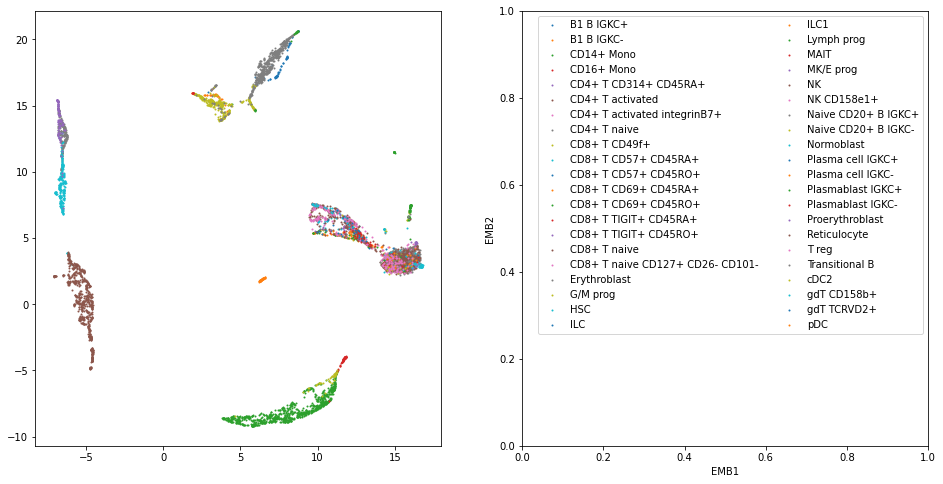

In [51]:
umap_cluster_labels = plot_embedding(umap_embedding, gex_labels)

Clustering metrics

In [52]:
get_clustering_metrics(umap_embedding, gex_labels)

Number of Leiden clusters: (32,)

    ARI: 0.32890764895158525

    AMI: 0.6249925740717046

    Homogenuity: 0.6473582343773157

    Completeness: 0.6278480932457938

    Avarage: 0.5572766376615998
    


(0.32890764895158525,
 0.6249925740717046,
 0.6473582343773157,
 0.6278480932457938)